## 📝 Dataset Description

### 📁 Files

* `train.csv` — The training set
* `test.csv` — The test set
* `sample_submission.csv` — A sample submission file in the correct format

---

### 📊 Columns

* **ID** — ID of the patient
* **A1\_Score to A10\_Score** — Scores based on the Autism Spectrum Quotient (AQ) 10-item screening tool
* **age** — Age of the patient in years
* **gender** — Gender of the patient
* **ethnicity** — Ethnicity of the patient
* **jaundice** — Whether the patient had jaundice at the time of birth
* **autism** — Whether an immediate family member has been diagnosed with autism
* **contry\_of\_res** — Country of residence of the patient
* **used\_app\_before** — Whether the patient has undergone a screening test before
* **result** — Score for AQ1–10 screening test
* **age\_desc** — Age description of the patient
* **relation** — Relation of the person who completed the test
* **Class/ASD** — Target column. Classified result as:

  * `0`: No autism
  * `1`: Yes (autism detected)
    This is the target column. During submission, values must be either `0` or `1` only.


**Importing Dependencies**

In [87]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 
import pickle
from sklearn.preprocessing import LabelEncoder 
from imblearn.over_sampling import SMOTE 
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier 
from xgboost import XGBClassifier 
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

### Data Collection and Cleaning

In [88]:
df = pd.read_csv('C:/Users/USER/Desktop/Datasets/autism_train.csv.csv')
df.head()

,ID,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,age,gender,ethnicity,jaundice,austim,contry_of_res,used_app_before,result,age_desc,relation,Class/ASD
0,1,1,0,1,0,1,0,1,0,1,1,38.172746,f,?,no,no,Austria,no,6.351166,18 and more,Self,0
1,2,0,0,0,0,0,0,0,0,0,0,47.750517,m,?,no,no,India,no,2.255185,18 and more,Self,0
2,3,1,1,1,1,1,1,1,1,1,1,7.380373,m,White-European,no,yes,United States,no,14.851484,18 and more,Self,1
3,4,0,0,0,0,0,0,0,0,0,0,23.561927,f,?,no,no,United States,no,2.276617,18 and more,Self,0
4,5,0,0,0,0,0,0,0,0,0,0,43.205790,m,?,no,no,South Africa,no,-4.777286,18 and more,Self,0


In [89]:
# number of rows and color 
df.shape

(800, 22)

In [90]:
# overview of the dataset 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               800 non-null    int64  
 1   A1_Score         800 non-null    int64  
 2   A2_Score         800 non-null    int64  
 3   A3_Score         800 non-null    int64  
 4   A4_Score         800 non-null    int64  
 5   A5_Score         800 non-null    int64  
 6   A6_Score         800 non-null    int64  
 7   A7_Score         800 non-null    int64  
 8   A8_Score         800 non-null    int64  
 9   A9_Score         800 non-null    int64  
 10  A10_Score        800 non-null    int64  
 11  age              800 non-null    float64
 12  gender           800 non-null    object 
 13  ethnicity        800 non-null    object 
 14  jaundice         800 non-null    object 
 15  austim           800 non-null    object 
 16  contry_of_res    800 non-null    object 
 17  used_app_before 

In [91]:
# convert the datatype of age column to integer 
df['age'] = df['age'].astype('int')

In [92]:
# Checking distinct values for each column
for coln in df.columns:
    num_features = ['ID', 'age', 'result']
    if coln not in num_features:
        print(coln, ':',df[coln].unique())
        print('_'*20)
        

A1_Score : [1 0]
____________________
A2_Score : [0 1]
____________________
A3_Score : [1 0]
____________________
A4_Score : [0 1]
____________________
A5_Score : [1 0]
____________________
A6_Score : [0 1]
____________________
A7_Score : [1 0]
____________________
A8_Score : [0 1]
____________________
A9_Score : [1 0]
____________________
A10_Score : [1 0]
____________________
gender : ['f' 'm']
____________________
ethnicity : ['?' 'White-European' 'Middle Eastern ' 'Pasifika' 'Black' 'Others'
 'Hispanic' 'Asian' 'Turkish' 'South Asian' 'Latino' 'others']
____________________
jaundice : ['no' 'yes']
____________________
austim : ['no' 'yes']
____________________
contry_of_res : ['Austria' 'India' 'United States' 'South Africa' 'Jordan'
 'United Kingdom' 'Brazil' 'New Zealand' 'Canada' 'Kazakhstan'
 'United Arab Emirates' 'Australia' 'Ukraine' 'Iraq' 'France' 'Malaysia'
 'Viet Nam' 'Egypt' 'Netherlands' 'Afghanistan' 'Oman' 'Italy'
 'AmericanSamoa' 'Bahamas' 'Saudi Arabia' 'Ireland' '

In [93]:
# drop columns 
df = df.drop(['ID', 'age_desc'], axis=1)
df.shape

(800, 20)

In [94]:
# mapping country name 
mapping = {
    'Viet Nam':'Vietnam',
    'Hong Kong':'China',
    'AmericanSamoa':'United States'
}

# replace value in the country column
df['contry_of_res'] = df['contry_of_res'].replace(mapping)

In [95]:
df['contry_of_res'].unique()

array(['Austria', 'India', 'United States', 'South Africa', 'Jordan',
       'United Kingdom', 'Brazil', 'New Zealand', 'Canada', 'Kazakhstan',
       'United Arab Emirates', 'Australia', 'Ukraine', 'Iraq', 'France',
       'Malaysia', 'Vietnam', 'Egypt', 'Netherlands', 'Afghanistan',
       'Oman', 'Italy', 'Bahamas', 'Saudi Arabia', 'Ireland', 'Aruba',
       'Sri Lanka', 'Russia', 'Bolivia', 'Azerbaijan', 'Armenia',
       'Serbia', 'Ethiopia', 'Sweden', 'Iceland', 'China', 'Angola',
       'Germany', 'Spain', 'Tonga', 'Pakistan', 'Iran', 'Argentina',
       'Japan', 'Mexico', 'Nicaragua', 'Sierra Leone', 'Czech Republic',
       'Niger', 'Romania', 'Cyprus', 'Belgium', 'Burundi', 'Bangladesh'],
      dtype=object)

In [96]:
df['ethnicity'].value_counts()

ethnicity
White-European     257
?                  203
Middle Eastern      97
Asian               67
Black               47
South Asian         34
Pasifika            32
Others              29
Latino              17
Hispanic             9
Turkish              5
others               3
Name: count, dtype: int64

In [97]:
df['ethnicity'] = df['ethnicity'].replace({'?':'Others', 'others':'Others'})

In [98]:
df['ethnicity'].value_counts()

ethnicity
White-European     257
Others             235
Middle Eastern      97
Asian               67
Black               47
South Asian         34
Pasifika            32
Latino              17
Hispanic             9
Turkish              5
Name: count, dtype: int64

In [99]:
# mapping country name 
mapping = {
    'Relative':'Others',
    'Parent':'Others',
    'Health care professional':'Others', 
    '?':'Others'
}

# replace value in the country column
df['relation'] = df['relation'].replace(mapping)

In [100]:
df['relation'].unique()

array(['Self', 'Others'], dtype=object)

**Label Encoding**

In [101]:
object_coln = df.select_dtypes(include=['object']).columns
print(object_coln)

Index(['gender', 'ethnicity', 'jaundice', 'austim', 'contry_of_res',
       'used_app_before', 'relation'],
      dtype='object')


In [102]:
encoders = {}

# apply label enecoding and store the encoder 
for coln in object_coln: 
    label_encoder = LabelEncoder()
    df[coln] = label_encoder.fit_transform(df[coln])
    encoders[coln] = label_encoder

# saving the encoders 
with open('encoders.pki', 'wb') as f:
    pickle.dump(encoders, f)

**Visualizing and Handling Outliers using IQR**

39
---------------------------------------------------------------------------


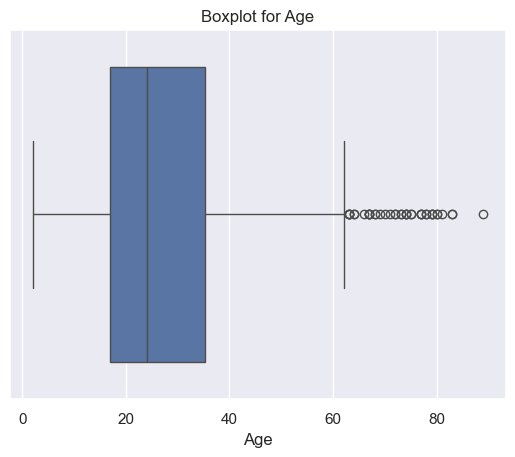

In [103]:
# outliers using IQR method
Q1 = df['age'].quantile(0.25)
Q3 = df['age'].quantile(0.75)

IQR = Q3 - Q1 
lower_bound = Q1 - 1.5 * IQR 
upper_bound = Q3 + 1.5 * IQR 

age_outliers = df[(df['age'] < lower_bound) | (df['age'] > upper_bound)]

# number of outliers 
print(len(age_outliers))
print('-'*75)
# boxplot for identifying outliers 
sns.boxplot(x=df['age']) 
plt.title('Boxplot for Age')
plt.xlabel('Age')
plt.show()

1
---------------------------------------------------------------------------


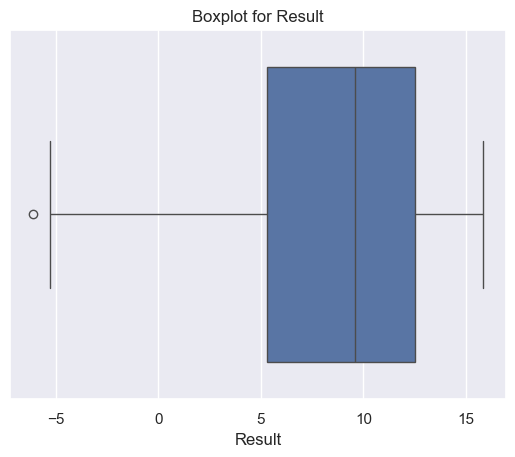

In [104]:
# outliers using IQR method
Q1 = df['result'].quantile(0.25)
Q3 = df['result'].quantile(0.75)

IQR = Q3 - Q1 
lower_bound = Q1 - 1.5 * IQR 
upper_bound = Q3 + 1.5 * IQR 

age_outliers = df[(df['result'] < lower_bound) | (df['result'] > upper_bound)]

# number of outliers 
print(len(age_outliers))
print('-'*75)
      
# boxplot for identifying outliers 
sns.boxplot(x=df['result']) 
plt.title('Boxplot for Result')
plt.xlabel('Result')
plt.show()

In [105]:
# funtion to replace outlier
def replace_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1 
    lower_bound = Q1 - 1.5 * IQR 
    upper_bound = Q3 + 1.5 * IQR 
    median = df[column].median()

    # replace outliers with median
    df[column] = df[column].apply(lambda x: median if x < lower_bound or x > upper_bound else x)
    return df

In [106]:
# replace outliers in the 'age' column 
df = replace_outliers(df, 'age')

# replace outliers in the 'result' column 
df = replace_outliers(df, 'result')

In [107]:
df.head()

,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,age,gender,ethnicity,jaundice,austim,contry_of_res,used_app_before,result,relation,Class/ASD
0,1,0,1,0,1,0,1,0,1,1,38.0,0,5,0,0,6,0,6.351166,1,0
1,0,0,0,0,0,0,0,0,0,0,47.0,1,5,0,0,23,0,2.255185,1,0
2,1,1,1,1,1,1,1,1,1,1,7.0,1,9,0,1,52,0,14.851484,1,1
3,0,0,0,0,0,0,0,0,0,0,23.0,0,5,0,0,52,0,2.276617,1,0
4,0,0,0,0,0,0,0,0,0,0,43.0,1,5,0,0,44,0,-4.777286,1,0


### Exploratory Data Analysis

In [108]:
# summary statistics 
df.describe()

,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,age,gender,ethnicity,jaundice,austim,contry_of_res,used_app_before,result,relation,Class/ASD
count,800.000000,800.000000,800.000000,800.00000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.00000,800.000000,800.000000,800.000000,800.000000,800.000000
mean,0.560000,0.530000,0.450000,0.41500,0.395000,0.303750,0.397500,0.508750,0.495000,0.617500,25.581250,0.662500,5.577500,0.231250,0.16375,32.558750,0.062500,8.556982,0.886250,0.201250
std,0.496697,0.499411,0.497805,0.49303,0.489157,0.460164,0.489687,0.500236,0.500288,0.486302,12.697142,0.473153,2.902503,0.421896,0.37028,16.300189,0.242213,4.779671,0.317706,0.401185
min,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,-5.264833,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,17.000000,0.000000,4.000000,0.000000,0.00000,23.000000,0.000000,5.311872,1.000000,0.000000
50%,1.000000,1.000000,0.000000,0.00000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,24.000000,1.000000,5.000000,0.000000,0.00000,33.000000,0.000000,9.608894,1.000000,0.000000
75%,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,32.000000,1.000000,9.000000,0.000000,0.00000,51.000000,0.000000,12.514484,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,62.000000,1.000000,9.000000,1.000000,1.00000,53.000000,1.000000,15.853126,1.000000,1.000000


In [109]:
# set theme 
sns.set_theme(style='darkgrid')

**Distribution of Age**

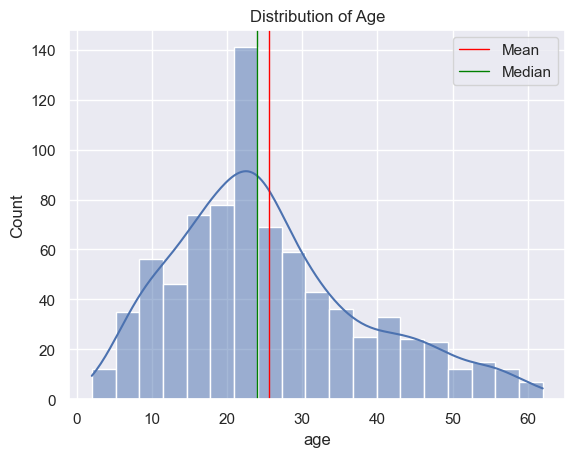

In [110]:
# distribution of age 
sns.histplot(df['age'], kde=True)
plt.title("Distribution of Age")

# calculating mean and median
age_mean = df['age'].mean()
age_median = df['age'].median()

# adding vertical lines for mean and median
plt.axvline(age_mean, color='red', linestyle='-', linewidth=1, label='Mean')
plt.axvline(age_median, color='green', linestyle='-', linewidth=1, label='Median')

plt.legend()
plt.show()

**Distribution of Result**

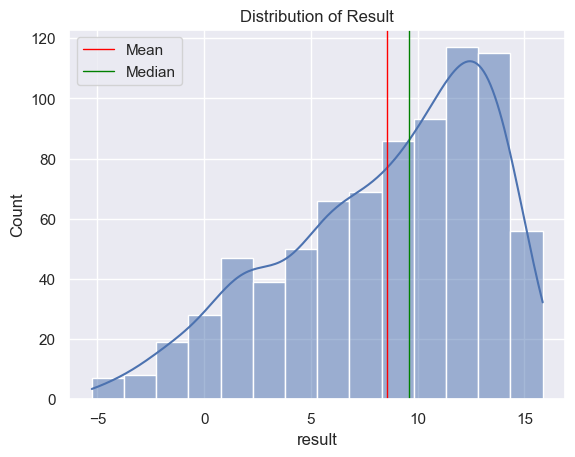

In [111]:
# distribution of result 
sns.histplot(df['result'], kde=True)
plt.title("Distribution of Result")

# calculating mean and median
age_mean = df['result'].mean()
age_median = df['result'].median()

# adding vertical lines for mean and median
plt.axvline(age_mean, color='red', linestyle='-', linewidth=1, label='Mean')
plt.axvline(age_median, color='green', linestyle='-', linewidth=1, label='Median')

plt.legend()
plt.show()

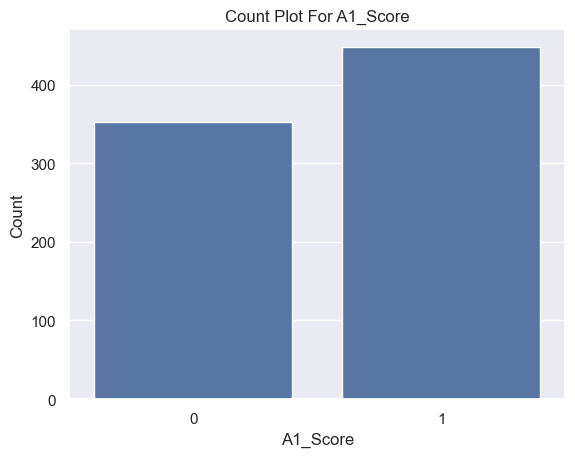

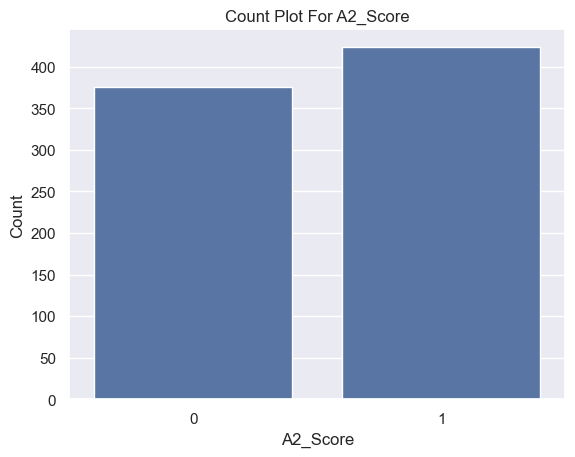

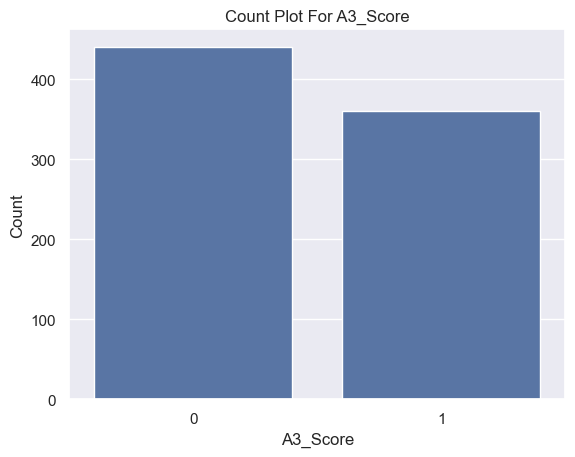

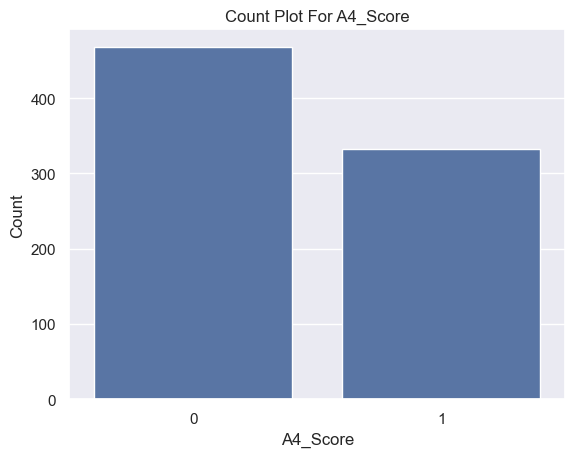

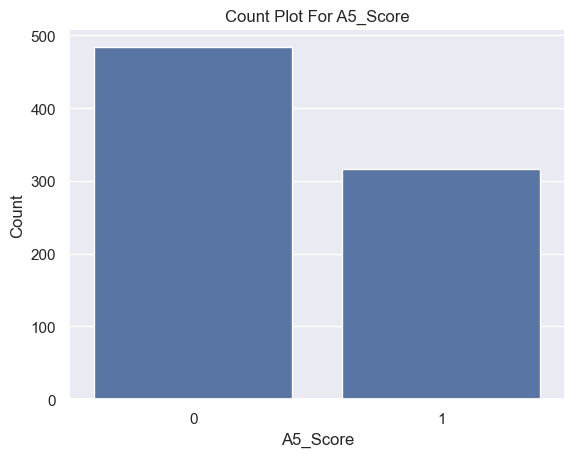

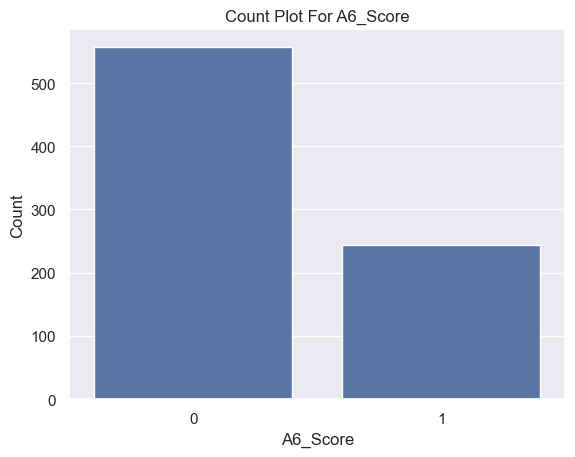

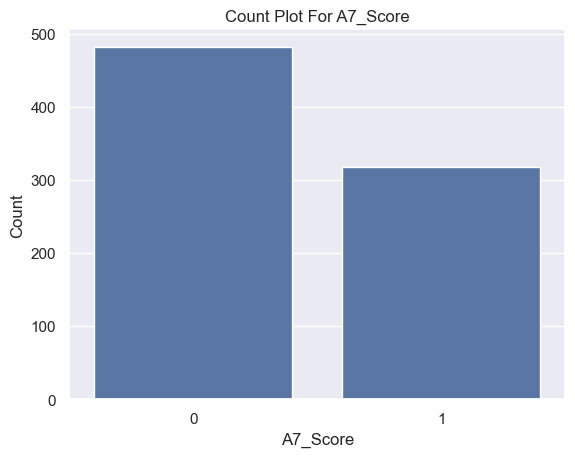

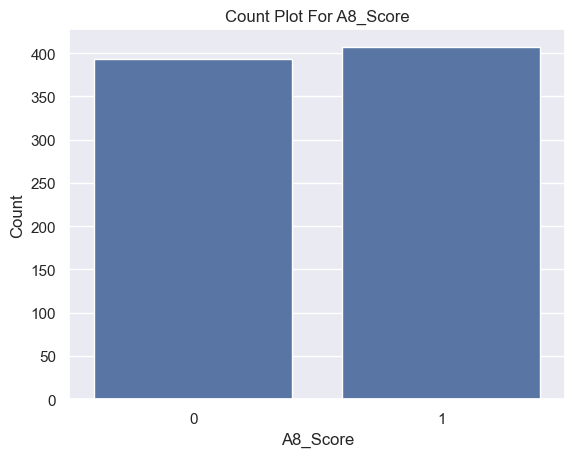

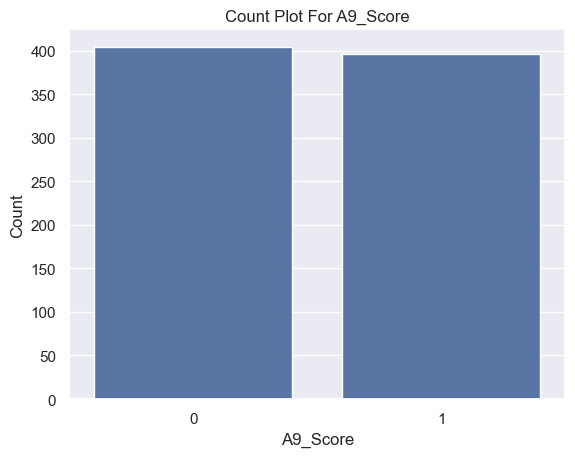

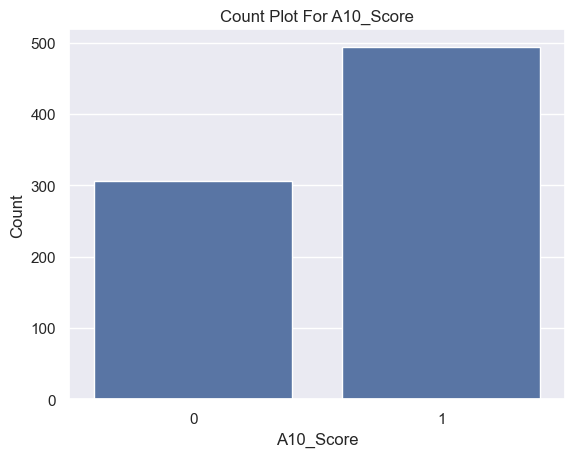

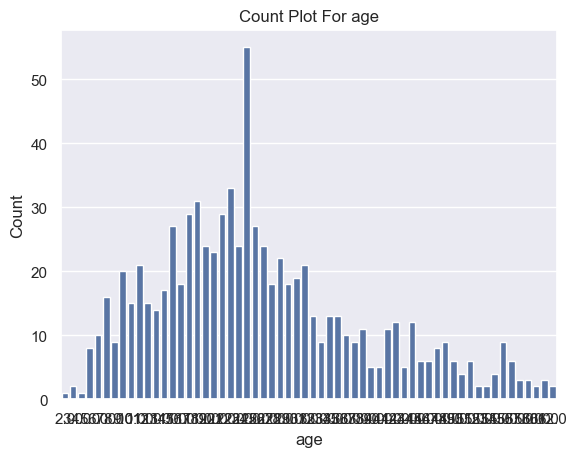

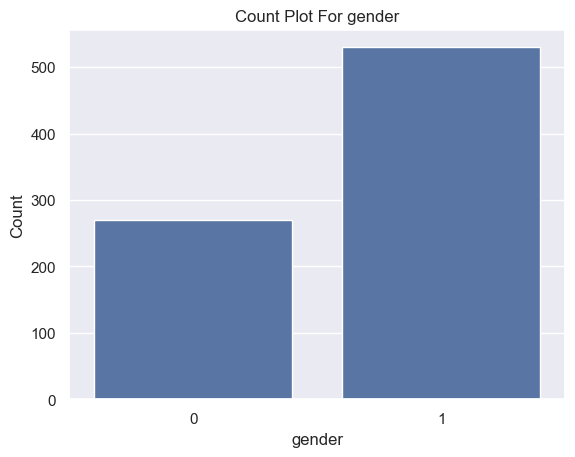

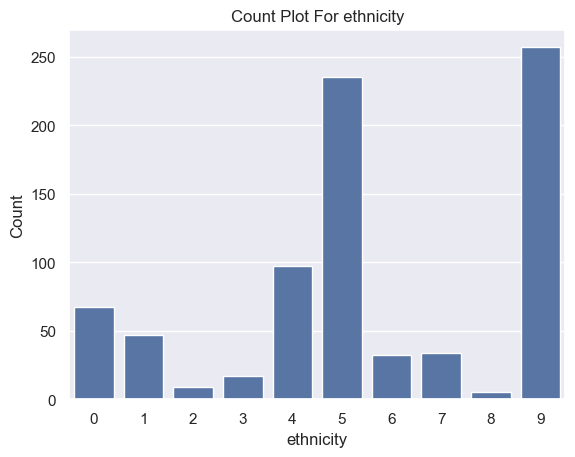

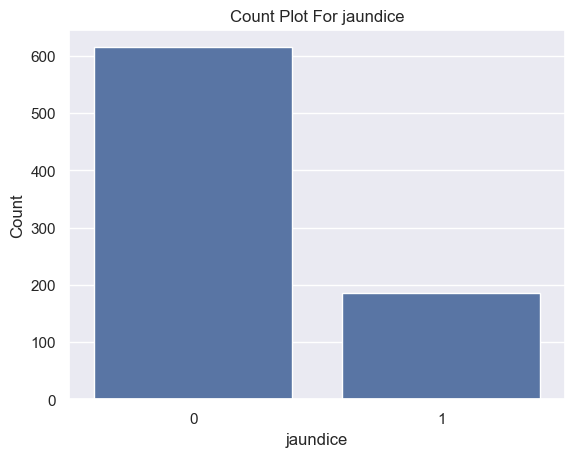

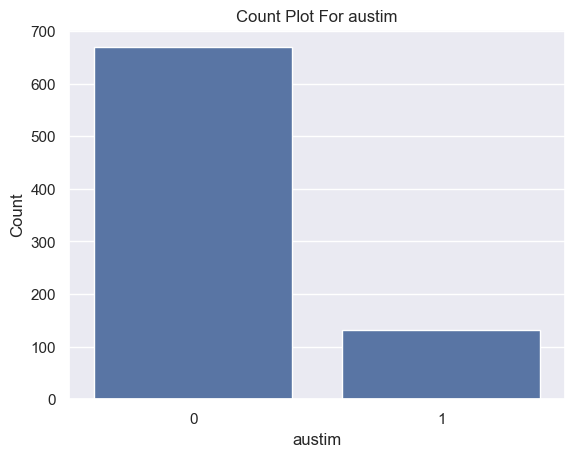

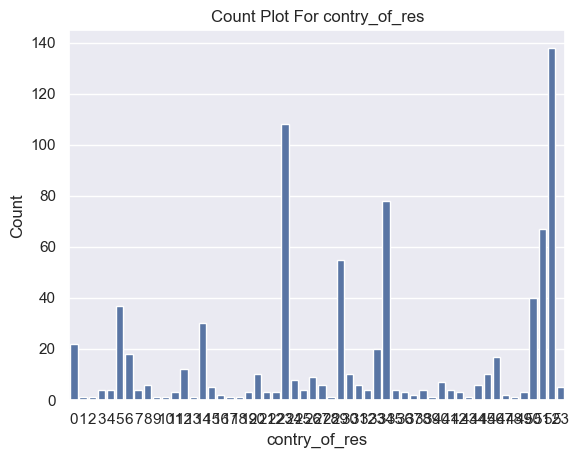

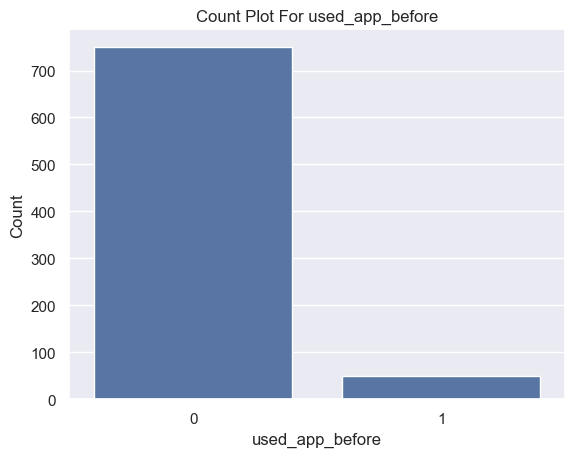

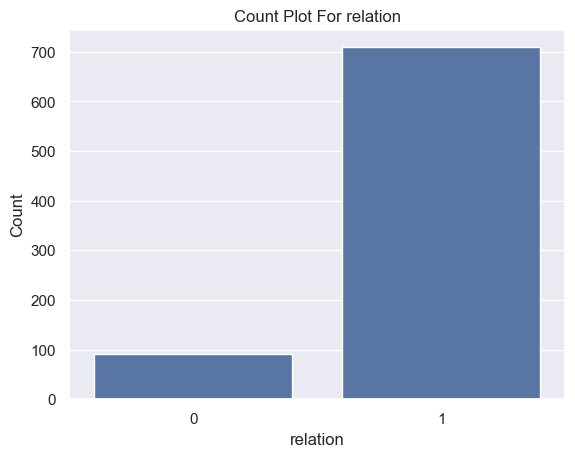

In [112]:
categorical_column = ['A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score',
       'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score', 'age', 'gender',
       'ethnicity', 'jaundice', 'austim', 'contry_of_res', 'used_app_before',
       'relation']

for coln in categorical_column: 
    sns.countplot(x=df[coln])
    plt.title(f"Count Plot For {coln}")
    plt.xlabel(coln)
    plt.ylabel('Count')
    plt.show()

**Target Distribution**

Target Variable Distribution: Class/ASD
0    639
1    161
Name: count, dtype: int64
--------------------------------------------------------------------------------


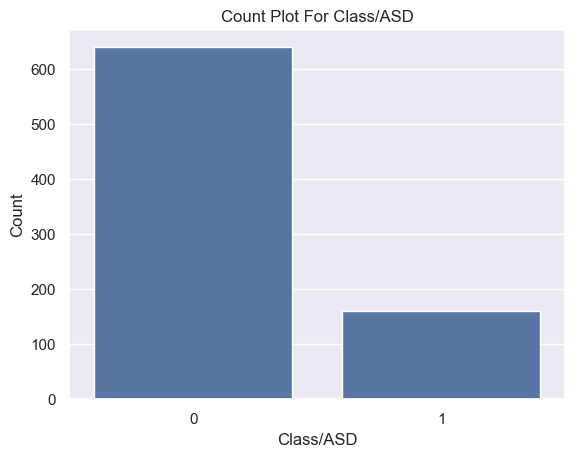

In [113]:
#Distribution of Class/ASD
print(f"Target Variable Distribution: {df['Class/ASD'].value_counts()}")
print('-'*80)

sns.countplot(x=df['Class/ASD'])
plt.title("Count Plot For Class/ASD")
plt.xlabel('Class/ASD')
plt.ylabel('Count')
plt.show()

**Correlation**

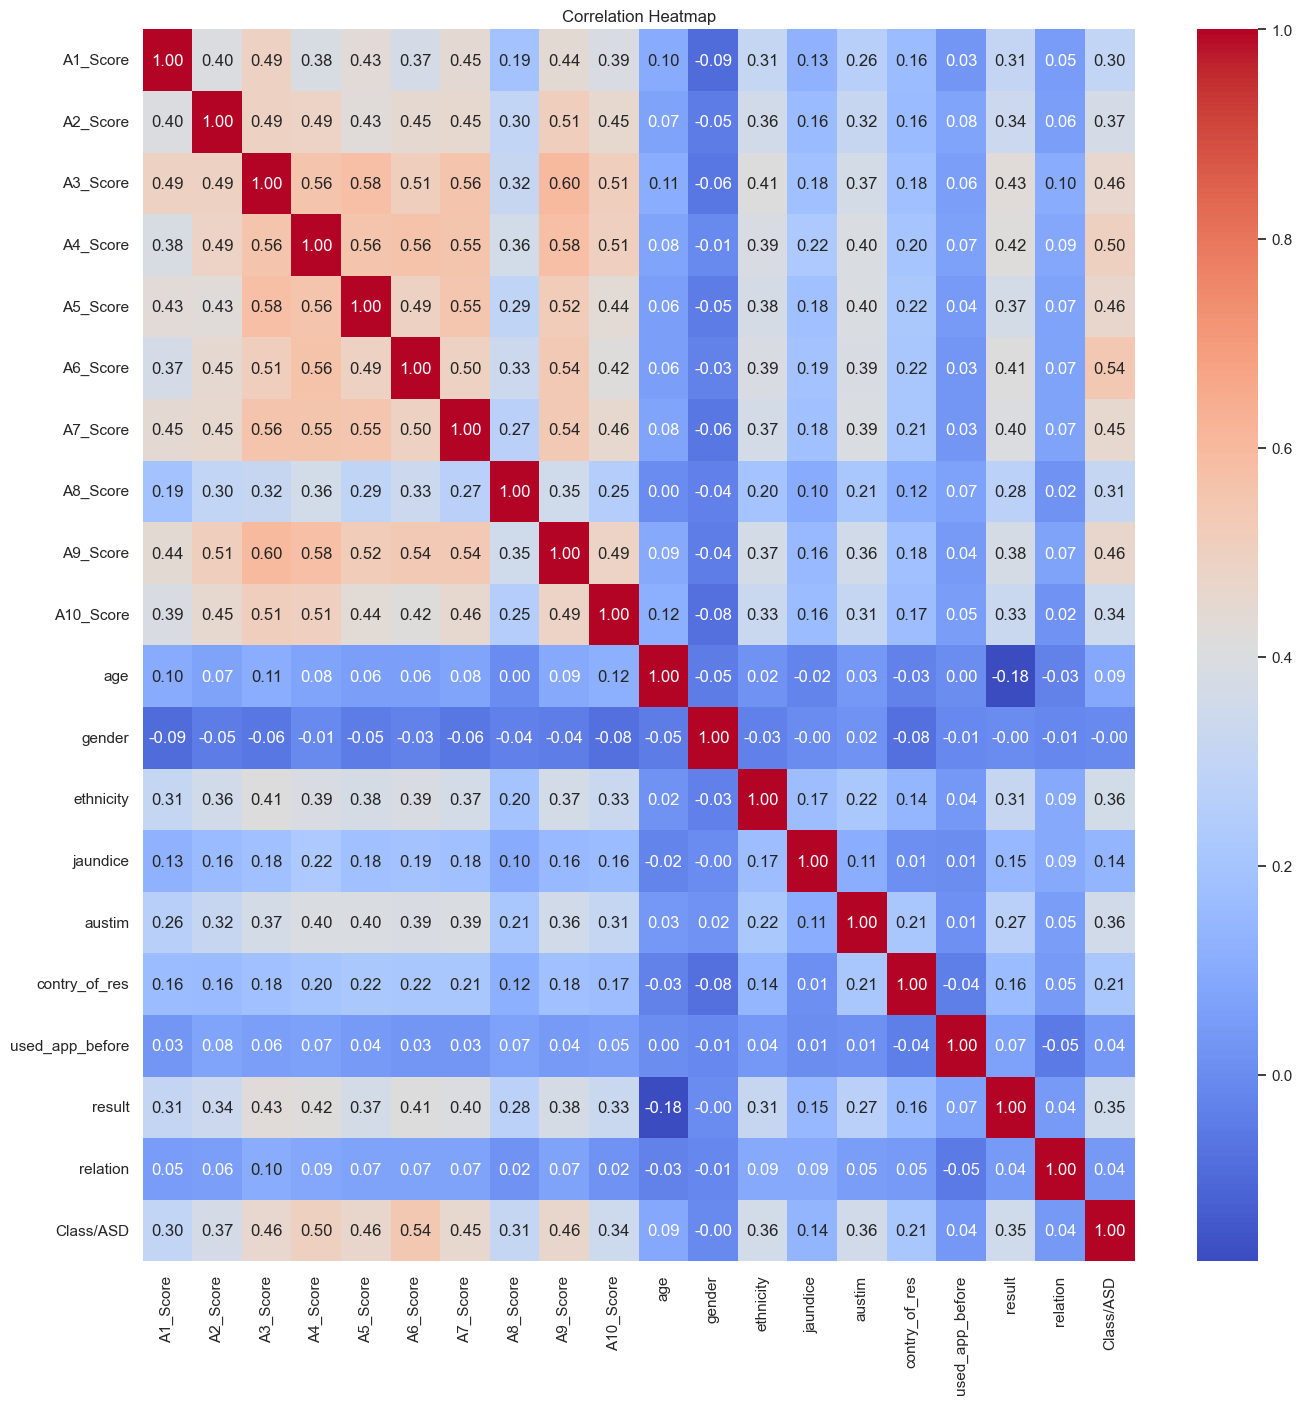

In [114]:
# correlation matrix 
plt.figure(figsize=[16, 16])
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

### Data Pre-Processing

**Seperating Features and Target**

In [115]:
X = df.drop('Class/ASD', axis=1)
y = df['Class/ASD']

In [116]:
print(X)

     A1_Score  A2_Score  A3_Score  A4_Score  A5_Score  ...  austim  contry_of_res  used_app_before     result  relation
0           1         0         1         0         1  ...       0              6                0   6.351166         1
1           0         0         0         0         0  ...       0             23                0   2.255185         1
2           1         1         1         1         1  ...       1             52                0  14.851484         1
3           0         0         0         0         0  ...       0             52                0   2.276617         1
4           0         0         0         0         0  ...       0             44                0  -4.777286         1
..        ...       ...       ...       ...       ...  ...     ...            ...              ...        ...       ...
795         0         1         0         0         0  ...       0             34                0  12.999501         1
796         0         1         1       

In [117]:
print(y)

0      0
1      0
2      1
3      0
4      0
      ..
795    0
796    0
797    0
798    0
799    0
Name: Class/ASD, Length: 800, dtype: int64


**Seperating Training and Test data**

In [118]:
X_trian, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=13)
print(X.shape, X_trian.shape, X_test.shape)

(800, 19) (680, 19) (120, 19)


In [119]:
y_train.value_counts()

Class/ASD
0    537
1    143
Name: count, dtype: int64

In [120]:
y_test.value_counts()

Class/ASD
0    102
1     18
Name: count, dtype: int64

**SMOTE(Synthentic Minority Oversampling Technique)**

In [121]:
smote = SMOTE(random_state=13)

In [122]:
X_train_smote, y_train_smote = smote.fit_resample(X_trian, y_train)

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


In [123]:
y_train_smote.shape

(1074,)

In [125]:
y_train_smote.value_counts()

Class/ASD
0    537
1    537
Name: count, dtype: int64

### Model Training

In [130]:
# classifiers 
models = {
    'Desicion Tree': DecisionTreeClassifier(random_state=13),
    'Random Forest': RandomForestClassifier(random_state=13),
    'XGBoost': XGBClassifier()
}

In [131]:
cv_score ={}

for model_name, model in models.items(): 
    print(f"training {model_name}")
    scores = cross_val_score(model, X_train_smote, y_train_smote, cv=5, scoring='accuracy')
    cv_score[model_name] = scores
    print(f'{model_name}, Cross validatin accuracy {np.mean(scores):.2f}')
    print('-'*20)

training Desicion Tree
Desicion Tree, Cross validatin accuracy 0.85
--------------------
training Random Forest
Random Forest, Cross validatin accuracy 0.90
--------------------
training XGBoost
XGBoost, Cross validatin accuracy 0.90
--------------------


### Model Selection and Hyperparamenter Tuning

In [132]:
# initializing models
decision_tree = DecisionTreeClassifier()
random_forest = RandomForestClassifier()
xgboost  = XGBClassifier()

In [134]:
# hyperparameter grids 
param_grid_dt = {
    'criterion':['gini', 'entropy'], 
    'max_depth':[None, 5, 10, 15, 20, 30, 50],
    'min_samples_split':[2, 5, 10],
    'min_sample_leaf':[1, 2, 4]
}

param_grid_rf = {
    'n_extimators':[50, 100, 200, 500], 
    'max_depth':[None, 10, 20, 30], 
    'min_samples_split':[2, 5, 10],
    'min_sample_leaf':[1, 2, 4], 
    'bootstrap':[True, False]

}

param_grid_xgb = {
    'n_extimators':[50, 100, 200, 500], 
    'max_depth':[3, 5, 7, 10], 
    'learning_rate':[0.01, 0.1, 0.2, 0.3], 
    'subsample':[0.5, 0.7, 1.0], 
    'colsample_bytree':[0.5, 0.7, 1.0]
}

In [ ]:
# hyperparameter tuning  for Decision tree
random_search_dt = RandomizedSearchCV(estimator=decision_tree, param_distributions=param_grid_dt,
                                      n_iter=20, cv=5, scoring='accuracy', random_state=13, n_jobs=-1)

random_search_rf = RandomizedSearchCV(estimator=random_forest, param_distributions=param_grid_rf,
                                      n_iter=20, cv=5, scoring='accuracy', random_state=13, n_jobs=-1)

random_search_xgb = RandomizedSearchCV(estimator=xgboost, param_distributions=param_grid_xgb,
                                       n_iter=20, cv=5, scoring='accuracy', random_state=13, n_jobs=-1)

